In [1]:
%load_ext autoreload
%autoreload 2
from Ge_calculation import GAP, MD_run
from Ge_analysis import *
import numpy as np
import os
from ase.atoms import Atoms
from quippy.potential import Potential
from quippy.descriptors import Descriptor
from ase.io import read
from ase.io.extxyz import read_xyz, write_xyz
import pymatgen.core.periodic_table as pt
import pymatgen.io.ase as pase
from sklearn import decomposition
from pyuoi.decomposition import CUR
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd

/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.coordinate_descent module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.lin

In [2]:
os.chdir('/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing')

In [ ]:
my = GAP('Si_myDB_64_125_216_train.xyz',
         val_file='Si_myDB_64_125_216_validate.xyz',
         pot='/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/Si_myDB_liqamo_loose.xml')

In [98]:
myDB = list(read_xyz('Si_myDB_64_125_216_train.xyz', index=slice(0, None)))

In [ ]:
def mult_min(v, Fmin):
    if v < Fmin:
        return Fmin
    else:
        return v
vmult_min = np.vectorize(mult_min)

In [ ]:
# Sets up the simple force-based reguliser. Kept for reference
for i in myDB:
    f = 0.1; Fmin = 0.01
    F = np.linalg.norm(i.get_array('dft_forces'), axis=1)
    s = f*vmult_min(F, Fmin)
    i.set_array('force_atom_sigma', s)

In [42]:
write_xyz('Si_myDB_fdreg_f0.1_Fmin0.01.xyz', myDB)

In [3]:
litDB = GAP('../Si_litDB_amoliq/gp_iter6_liqamo.xyz',
            val_file='Si_myDB_64_125_216_validate.xyz',
            pot='../Si_litDB_amoliq/Si_litDB_liqamo.xml',
            parameter_names=['dft_energy', 'dft_forces', 'dft_virial'])

training set structure count: 236
validation set structure count: 70
reading xyz file (may take a while)
read configs, now fixing virials
config labels: ['liq', 'amorph']


In [4]:
litDB_test = GAP('../Si_litDB_amoliq/gp_iter6_liqamo.xyz',
            val_file='Si_myDB_64_125_216_validate.xyz',
            pot='../Si_litDB_amoliq/Si_litDB_liqamo.xml',
            parameter_names=['dft_energy', 'dft_forces', 'dft_virial'])

training set structure count: 236
validation set structure count: 70
reading xyz file (may take a while)
read configs, now fixing virials
config labels: ['liq', 'amorph']


In [ ]:
litDB.calc()
litDB.analyse()
litDB.save('litDB_pickle')

25.0% done
50.0% done
75.0% done


In [5]:
litDB_test.load('litDB_pickle')
litDB_test.analyse()

Load successful
data_dict:  dict_keys(['QM_E_t', 'QM_F_t', 'QM_V_t', 'QM_E_v', 'QM_F_v', 'QM_V_v', 'T_configs', 'V_configs', 'GAP_E_t', 'GAP_F_t', 'GAP_V_t', 'E_err_t', 'F_err_t', 'V_err_t', 'E_rmse_t', 'F_rmse_t', 'V_rmse_t', 'GAP_E_v', 'GAP_F_v', 'GAP_V_v', 'E_err_v', 'F_err_v', 'V_err_v', 'E_rmse_v', 'F_rmse_v', 'V_rmse_v'])


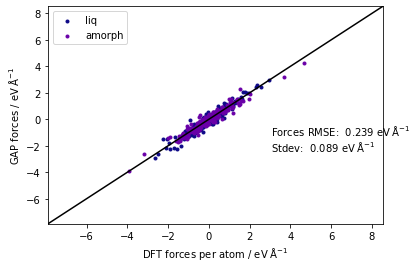

<AxesSubplot:xlabel='DFT forces per atom / $\\mathrm{eV\\;Å^{-1}}$', ylabel='GAP forces / $\\mathrm{eV\\;Å^{-1}}$'>

In [6]:
forces_error(litDB_test)

In [ ]:
ferr = np.array(flatten(litDB.data_dict['F_err_v']))

In [ ]:
ferr = ferr.reshape(-1,3)
ferr_norm = np.linalg.norm(ferr.reshape(-1, 3), axis=1)

In [11]:
dia = bulk('Si', 'diamond')

In [3]:
def kernel_mat(cfgs,
                desc=Descriptor('soap average=T l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'),
                zeta=4):
    '''calculates the average/std dev similarity kernel matrix among a set of
    configs.
    should do it more efficiently using symmetry einsum
    '''
    descs = np.array(flatten(desc.calc_descriptor(cfgs)))
    descs = descs.reshape(-1, descs.shape[-1]) # flatten out all the environs
    print(descs.shape)
    k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))
    np.nan_to_num(k, copy=False)
    pca = decomposition.PCA(n_components=2)
    pca.fit(k)
    red = pca.fit_transform(k)

    return k, red

In [14]:
k = kernel_compare(flatten(litDB.V_configs), dia,
               desc=Descriptor('soap average=F l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'))

(547,)


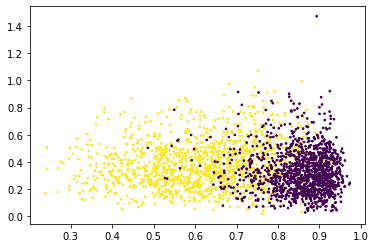

In [19]:
plt.scatter(k, ferr_norm, s=3, marker='x', c=cmap)

In [17]:
cfg_lab = flatten([[i.info['config_type'] for j in range(len(i))] for i in flatten(litDB.V_configs)])

In [63]:
cmap = np.unique(cfg_lab, return_inverse=True)[1]

Below: the way to extract predicted energy errors. A longer-term project is
to figure out how to get the predicted force error and variance on the total energy

In [38]:
pot = Potential(param_filename='/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/Si_myDB_64_125_216.xml',
                calc_args='local_gap_variance')

In [41]:
pot.calculate(litDB.V_configs[0][0],
                args_str='local_gap_variance', copy_all_results=True)

# Begin:
playing around with looking for correlations between predicted errors,
actual errors (energy, force), and similarity kernels. Analysis needs to be
repeated for the half/half split data (only done for a toy system at the moment)

In [48]:
gp_var = []
gp_var_grad = []
for i in flatten(litDB.V_configs):
    pot.calculate(i,
                    args_str='local_gap_variance', copy_all_results=True)
    gp_var.append(pot.atoms.arrays['local_gap_variance'])
    gp_var_grad.append(pot.atoms.arrays['gap_variance_gradient'])

In [57]:
grad_s = np.concatenate(gp_var_grad, axis=0)
var_s = np.concatenate(gp_var, axis=0)

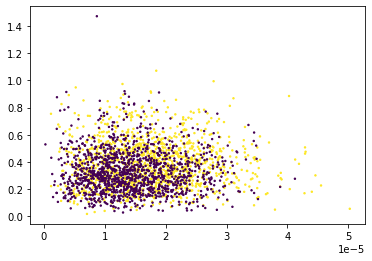

In [66]:
plt.scatter(np.linalg.norm(grad_s, axis=1), ferr_norm, s=2, c=cmap)

In [ ]:
plt.scatter(np.linalg.norm(grad_s, axis=1), k, s=2)

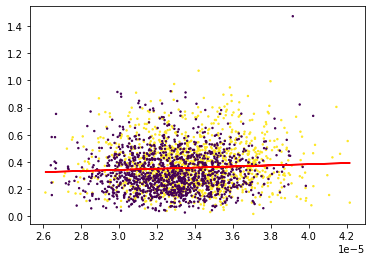

In [73]:
plt.scatter(var_s, ferr_norm, s=2, c=cmap)
plt.plot(var_s, m*var_s + c, 'r')

In [72]:
A = np.vstack([var_s, np.ones(len(var_s))]).T
m, c = np.linalg.lstsq(A, ferr_norm)[0]

<ipython-input-72-0fb3b2028595>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, ferr_norm)[0]


In [ ]:
pearsonr(var_s, ferr_norm)

In [170]:
pearsonr(np.linalg.norm(grad_s, axis=1), ferr_norm)

(0.024289188864454164, 0.2118334378140808)

In [181]:
pearsonr(var_s, k)

(0.03994968187441616, 0.03997038234928885)

In [168]:
pearsonr(np.linalg.norm(grad_s, axis=1), k)

(-0.10158178086429231, 1.6552743411070796e-07)

In [90]:
desc = Descriptor('soap average=F l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0')

In [95]:
mean_desc = np.concatenate(desc.calc_descriptor(flatten(litDB.V_configs)), axis=0).mean(axis=0)

In [180]:
k = kernel_compare(flatten(litDB.V_configs), mean_desc,
                   desc=Descriptor('soap average=F l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'))

(547,)


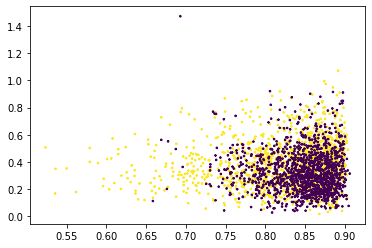

In [109]:
plt.scatter(k, ferr_norm, s=3, marker='x', c=cmap)

In [116]:
gf = np.array(flatten(litDB.gap_v[1])).reshape(-1,3)
qf = np.array(flatten(litDB.qm_v[1])).reshape(-1,3)

In [176]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector, axis=1)[:, np.newaxis]

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.einsum('ij,ij->i', v1_u, v2_u), -1.0, 1.0))

In [177]:
ang_err = angle_between(qf, gf)

In [178]:
pearsonr(ang_err, k)

(-0.0792751244855293, 4.487899333148556e-05)

In [179]:
pearsonr(ang_err, var_s)

(-0.022212881160306435, 0.2535439939833207)

In [187]:
print(k.mean(), k.std())

0.8363387319941057 0.05490302403872639


Select the most extreme environments and look for correlations there (most susceptible to overfitting)

In [234]:
liqs = litDB.V_configs[0]
k_liq = kernel_compare(liqs, mean_desc,
                   desc=Descriptor('soap average=F l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'))
mean_desc_l = np.concatenate(desc.calc_descriptor(liqs), axis=0).mean(axis=0)
ferr_l = np.array(litDB.data_dict['F_err_v'][0])
ferr_l = ferr_l.reshape(-1,3)
ferr_norm_l = np.linalg.norm(ferr_l.reshape(-1, 3), axis=1)
var_l = var_s[0:sum([len(i) for i in litDB.V_configs[0]])]
grad_l = np.linalg.norm(grad_s[0:sum([len(i) for i in litDB.V_configs[0]])], axis=1)

(547,)


In [273]:
outliers = k_liq[(argbool := k_liq < (k_liq.mean()-1*k_liq.std()))]
outliers_g = k_liq[(rgbool_g := k_liq > (k_liq.mean()+1*k_liq.std()))]
gf_l = np.array(litDB.gap_v[1][0]).reshape(-1,3)
qf_l = np.array(litDB.qm_v[1][0]).reshape(-1,3)
ang_err_l = angle_between(gf_l, qf_l)

In [274]:
print(pearsonr(var_l[argbool], outliers), '\n')

print(pearsonr(ferr_norm_l[argbool], outliers))
print(pearsonr(ferr_norm_l[argbool], var_l[argbool]))
print(pearsonr(ferr_norm_l[argbool], grad_l[argbool]), '\n')

print(pearsonr(ang_err_l[argbool], outliers))
print(pearsonr(ang_err_l[argbool], var_l[argbool]))
print(pearsonr(ang_err_l[argbool], grad_l[argbool]))

(0.07694285167058593, 0.29007353961833193) 

(0.09022948106386047, 0.21447859785955498)
(-0.1919312875008827, 0.00781623113241208)
(-0.024171193440905677, 0.7399585608252441) 

(-0.018925039635411922, 0.79497512974134)
(-0.15252166012433926, 0.035170122223392705)
(-0.05487320344505174, 0.4508774853943471)


In [271]:
print(pearsonr(ferr_norm_l, k_liq))
print(pearsonr(ferr_norm_l, var_l))
print(pearsonr(ferr_norm_l, grad_l), '\n')

print(pearsonr(ang_err_l, k_liq))
print(pearsonr(ang_err_l, var_l))
print(pearsonr(ang_err_l, grad_l))

(0.0905854080939325, 0.0009762303060705807)
(0.019644095132693794, 0.4754503614387083)
(-0.003906080330446343, 0.8871679896803195) 

(-0.07052388401604816, 0.010318506720519536)
(-0.10657482554153827, 0.00010343732687283775)
(-0.04533072436611913, 0.09945900984245086)


In [213]:
pearsonr(var_s[argbool_g], outliers_g)

(-0.018350343947079663, 0.8073768866093685)

look at the liquid configurations?

Splitting the full DB in two for testing of the custom reg.

train and test DBs constructed from completely separate runs appears to give a failed quench
(unlike the mixed version stored under 'boz'). This confirms previous hunches that uncorrelated configurations
provide beneficial diversity

Options:
* further MD run to confirm this (is it instability or repeated failure)
* test run on the other half (with default regularisation)
* could try and optimise the reg to improve mutual predicted errors (and see if this fixes the problem)

In [325]:
myDB_full = list(read_xyz('/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/train_64_125_216_full.xyz',
                          index=slice(0,None)))

In [280]:
def reduce_DB(xyz, gen_red=1, ctypes = [None], outfile=None, size_dep_prob={}):
    '''Reduces a database's configuration count for robustness stress-testing
    ctypes: list of str, config_types to keep in new DB. Leave None for all
    size_dist: dict, sizes and their desired relative fractions
    outfile: str, optional custom name for new DB file'''
    r = np.random.rand
    ats = list(read_xyz(xyz, index=slice(0,None)))
    sizes = np.unique([len(i) for i in ats])
    for i in sizes:
        if str(i) not in size_dep_prob.keys():
            size_dep_prob.update({str(i):1})
    ini = sum([len(i) for i in ats])
    keeps = []
    ct = 0; ct_kept = 0; popped = []

    for i in range(len(ats)-1, -1, -1):
        if r() > gen_red and len(ats[i]) != 1:
            popped.append(ats.pop(i))

    for i in range(len(ats)-1, -1, -1):
        if r() > size_dep_prob[str(len(ats[i]))]:
            popped.append(ats.pop(i))

    for i, val in enumerate(ats):
        if (val.info['config_type'] in ctypes or 'isol' in val.info['config_type'] or None in ctypes):
            keeps.append(val)
        else:
            popped.append(val)


    if outfile is None:
        outfile = xyz.split('.')[:-1] + '_red.xyz'
        valfile = xyz.split('.')[:-1] + '_extraval.xyz'

    write_xyz(outfile, keeps)

    print('total {0} popped\n'.format(len(popped)))
    print('final fraction = {:2.2f}%'.format(100*sum([len(i) for i in keeps])/ini))
    print_DB_stats(keeps)

    return keeps, popped

Need to fit the first potential in order to get some predicted errors in the next

In [438]:
half1 = list(read_xyz('half_split/half1_control.xyz', index=slice(0, None)))
half2 = list(read_xyz('half_split/half2_test.xyz', index=slice(0, None)))
pot1 = Potential(param_filename='half_split/half1_control.xml',
                 calc_args='local_gap_variance')

In [439]:
for i in half2:
    pot1.calculate(i, args_str='local_gap_variance', copy_all_results=True)
    # f = 0.1; Fmin = 0.01
    # F = np.linalg.norm(i.get_array('dft_forces'), axis=1)
    # s = f*vmult_min(F, Fmin)
    # i.set_array('force_atom_sigma', s)

In [441]:
half2[1].arrays.keys()

dict_keys(['numbers', 'positions', 'dft_force', 'forces', 'local_gap_variance', 'gap_variance_gradient'])

In [442]:
np.sqrt(np.sum(half2[1].arrays['local_gap_variance']))

0.044306018587140124

In [ ]:
half2[1].arrays['gap_variance_gradient']

In [446]:
t = np.array([])
e = []
for i in half2:
    i.set_array('force_atom_sigma', 15500*i.arrays['local_gap_variance'])
    i.info['energy_sigma'] = np.sqrt(np.sum(i.arrays['local_gap_variance']))
    t = np.concatenate((t, 15500*half2[18].arrays['local_gap_variance']), axis=0)
    e.append(np.sqrt(np.sum(i.arrays['local_gap_variance'])))

In [452]:
write_xyz('half_split/half2_FEregv1_15500.xyz', half2, columns=['symbols',
                                                          'numbers',
                                                          'positions',
                                                          'dft_force',
                                                          'force_atom_sigma'])

Now repeating correlation analysis for the real half-split. The fit seems very sensitive to regularisation now (double
or half both fail with the full DB)

* try and correlate actual error with reg setting
* correlate actual error with predicted error

In [6]:
h1_pot = Potential(param_filename='half_split/half1_control.xml',
                 calc_args='local_gap_variance')
h1_DB = list(read_xyz('half_split/half1_control.xyz', index=slice(0,None)))
h2_DB = list(read_xyz('half_split/half2_test.xyz', index=slice(0,None)))

In [12]:
for i in h2_DB:
    h1_pot.calculate(i, args_str='local_gap_variance', copy_all_results=True)

In [ ]:
h2_DB[1].arrays

In [14]:
for i in h1_DB:
    h1_pot.calculate(i, args_str='local_gap_variance', copy_all_results=True)

In [9]:
h1_DB_GAP = GAP('half_split/half1_control.xyz', val_file='half_split/half2_test.xyz',
                parameter_names=('dft_energy', 'dft_force', 'dft_virial'), pot=h1_pot)

training set structure count: 176
validation set structure count: 176
reading xyz file (may take a while)
read configs, now fixing virials
config labels: ['amorph', 'inter', 'hiT_amorph', 'liq', 'hiT_liq']


In [10]:
h1_DB_GAP.calc(variance=True)

25.0% done
50.0% done
75.0% done
25.0% done
50.0% done
75.0% done
--- 338.1137914657593 seconds ---


In [17]:
h1_DB_GAP.analyse()
h1_DB_GAP.save('h1_DB_GAP_pickle')

## Correlation mining on half-split:

In [ ]:
h1_DB_GAP.data_dict['F_rmse_v']

## Systematic application of pots to train/val sets:
run this when I have to go out at some point (will take an hour or so)

In [21]:
pot_strs = ['Si_myDB_cdr_loose_amo.xml', 'Si_myDB_cdr_loose_liq.xml',
            'Si_myDB_ds0.001_0.5_0.05_0.0.xml', 'Si_myDB_ds0.025_0.25_0.125_0.0.xml',
            'Si_myDB_ds0.075_0.75_0.375_0.0.xml', 'Si_myDB_ds0.1_1.0_0.5_0.0.xml',
            'Si_myDB_fdreg_f0.1_Fmin0.01.xml']

regcomp_GAP = GAP('half_split/half1_control.xyz', val_file='half_split/half2_test.xyz',
                parameter_names=('dft_energy', 'dft_force', 'dft_virial'),
                  pot='../Si_litDB_amoliq/Si_litDB_liqamo.xml')

training set structure count: 176
validation set structure count: 176
reading xyz file (may take a while)
read configs, now fixing virials
config labels: ['amorph', 'inter', 'hiT_amorph', 'liq', 'hiT_liq']


In [22]:
# This will be expensive
regcomp_GAP.calc(variance=True)
for i in pot_strs:
    regcomp_GAP.calc_extra(pot=i, variance=True)

regcomp_GAP.save('regcomp_GAP.pickle')

25.0% done
50.0% done
75.0% done
25.0% done
50.0% done
75.0% done
--- 331.1138322353363 seconds ---
25.0% done
50.0% done
75.0% done
25.0% done
50.0% done
75.0% done
--- 990.1644549369812 seconds ---
3
25.0% done
50.0% done
75.0% done
25.0% done
50.0% done
75.0% done
--- 936.8145308494568 seconds ---
3
25.0% done
50.0% done
75.0% done
25.0% done
50.0% done
75.0% done
--- 916.0861518383026 seconds ---
3
25.0% done
50.0% done
75.0% done
25.0% done
50.0% done
75.0% done
--- 916.7249004840851 seconds ---
3
25.0% done
50.0% done
75.0% done
25.0% done
50.0% done
75.0% done
--- 919.0530595779419 seconds ---
3
25.0% done
50.0% done
75.0% done
25.0% done
50.0% done
75.0% done
--- 922.0938429832458 seconds ---
3
25.0% done
50.0% done
75.0% done
25.0% done
50.0% done
75.0% done
--- 927.8418416976929 seconds ---
3


## Analysis of MD runs
Statistics we may want to consider
* average + std-dev C.N.s
* SOAP kernels
* Structure factors and pdfs - height of first sharp peak?
* ring statistics
* adfs
* tetrahedal edge vs corner sharing

In [3]:
lSi_exp_Sq = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/Si_Sq_exp_Waseda1974.txt',
                          delimiter=', ').T
lSi_exp_Sq[1] += -0.5

aSi_exp_Sq = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/a-Si_x-ray_Laaziri1999.txt',
                          delimiter=', ').T
aSi_exp_gr = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/aSi-g-Lannin1988.txt',
                          delimiter=', ').T
Si_exp_lADF = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/l-Si_ADF_Bartok2018_DFT.txt',
                          delimiter=', ').T
Si_exp_lADF_GAP = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/l-Si_ADF_Bartok2018_GAP.txt',
                          delimiter=', ').T
Si_exp_RDF = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/l-Si_RDF_Bartok2018_DFT.txt',
                          delimiter=', ').T
Si_lGAP_RDF = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/l-Si_RDF_Bartok2018_GAP.txt',
                          delimiter=', ').T

In [4]:
MD_64dirs = [i for i in os.listdir() if 'run_64' in i]

In [5]:
run_64s = [MD_run(i, label=i[15:]) for i in MD_64dirs]

In [100]:
run_64s[0].df.head()

,Configs,CPU,Temp,f_TempAve,Press,f_PressAve,f_PEAve_Atom,Volume,f_vAve,c_MSD[4]
1000,"(Atom('Si', [0.8508668068799999, 2.30711334480...",28.866737,2278.0362,2391.8804,19253.7610,6628.37190,-168.25783,1178.3841,1207.2065,18.770894
2000,"(Atom('Si', [2.7636607764000005, 2.6583263316,...",57.680754,2298.7420,2448.6788,-2205.7163,458.69348,-168.27429,1250.8998,1192.7404,35.510943
3000,"(Atom('Si', [4.6136614425, 4.3090206659999994,...",86.468087,2714.3556,2579.7369,14727.1410,-2450.94100,-168.26107,1178.7536,1235.3188,53.624327
4000,"(Atom('Si', [0.4368036314, 3.984785602, 2.2398...",115.359910,2581.2520,2494.9962,-4158.7018,-4313.32400,-168.28352,1213.4066,1205.3528,70.607144
5000,"(Atom('Si', [0.15366458008, 3.6898791215, 0.47...",144.196870,2738.3179,2569.9804,32275.9710,2315.97570,-168.29367,1112.2374,1175.2594,86.292029


### Coordination statistics

In [7]:
cns = np.array([cn_count(i.df['Configs'][240000])[1] for i in run_64s])

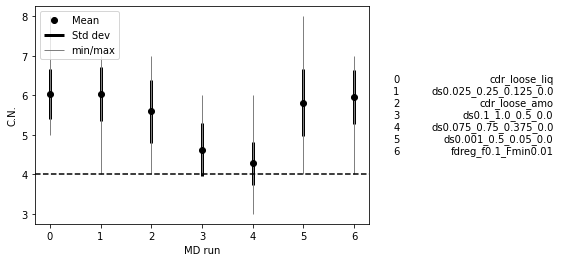

In [14]:
mins = cns.min(1)
maxs = cns.max(1)
means = cns.mean(1)
std = cns.std(1)

fig, axs = plt.subplots()
l1 = axs.errorbar(np.arange(n := len(run_64s)), means, std, fmt='ok', lw=3)
l2 = axs.errorbar(np.arange(n), means, [means - mins, maxs - means],
             fmt='.k', ecolor='gray', lw=1)
axs.axhline(4, color='k', linestyle='--')
axs.table(cellText=np.array([np.arange(n), [i.label for i in run_64s]]).T,
          edges='', loc=14, colWidths=[0.1,0.5])
axs.set(xlabel='MD run', ylabel='C.N.')
axs.legend([l1[0], l1[2], l2[2]], ('Mean', 'Std dev', 'min/max'), loc='upper left')
fig.savefig('/home/joe/OneDrive/slack_figures/reg_CNs.png', dpi=100, bbox_inches='tight')

In [ ]:
### Structure factors, angles and pdfs

In [9]:
for i in run_64s:
    i.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='Sq_'+i.label,
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True)

    i.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
    i.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])

[(1.0, 12.0)]

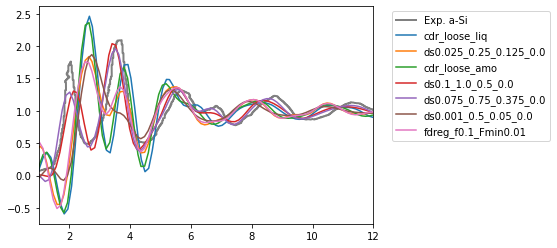

In [29]:
fig, axs = plt.subplots()
for i in run_64s:
    axs.errorbar(*i.Sq_x_av[1], yerr=None,
                label=i.label)
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=2, label='Exp. a-Si')
axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
axs.set(xlim=(1,12))

In [19]:
for i in run_64s:
    i.bin_bond_angle(s_selection=range(90,110))

/home/joe/PycharmProjects/Ge_analysis_local/Ge_calculation.py:494: RuntimeWarning: Mean of empty slice.
  self.bond_angle_av.append(np.array([[x[dig == i].mean() for i in range(1, len(bins))],
/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/joe/PycharmProjects/Ge_analysis_local/Ge_calculation.py:495: RuntimeWarning: Mean of empty slice.
  [y[dig == i].mean() + 1 for i in range(1, len(bins))]]))
/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/joe/miniconda3/envs/Q/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: 

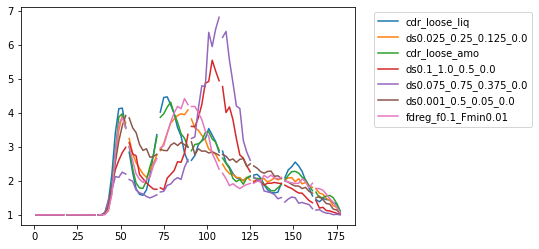

In [31]:
fig, axs = plt.subplots()
for i in run_64s:
    axs.plot(*i.bond_angle_av[0], label=i.label)

axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

In [22]:
for i in run_64s:
    i.bin_fit_g(nbins=40, s_selection=range(90,110), r_selection=[0.8,6])

NameError: name 'run_64s' is not defined

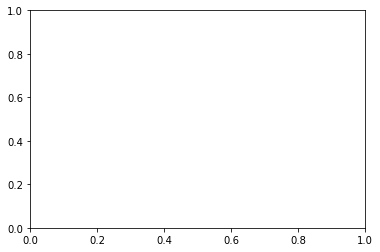

In [3]:
fig, axs = plt.subplots()
for i in run_64s:
    axs.plot(*i.gr_av[0] - 1, label=i.label)
axs.plot(*aSi_exp_gr, label='a-Si exp.', color='Gray')
axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

## Place for figuring out how to access predicted errors
Summing variances:
$\mathbb{V}$[x+y] = $\mathbb{V}$[x] + $\mathbb{V}$[y] + Cov[x,y] + Cov[y,x]

$\text{Var}\bigg(\sum_{i=1}^m X_i\bigg) = \sum_{i=1}^m \text{Var}(X_i) + 2\sum_{i\lt j} \text{Cov}(X_i,X_j)$

problem is that the complete prediction covariance matrices are not readily available (may be accessible
from knowledge of the kernels, read about Gaussian processes to understand more)

In [ ]:
def sum_var(var_list):
    cov = np.cov()
    var = np.sum(var_list) + 2*scipy.stats.cov

## Syntax & small model testing below here


In [33]:
h1_DB_GAP.pot.name

''

In [35]:
a = [1,2]
c,d = a
print(c,d)

1 2


In [7]:
small_DB = GAP('small_test_DB.xyz', val_file='small_test_DB_val.xyz', pot=h1_pot,
               parameter_names=('dft_energy', 'dft_forces', 'dft_virial'))

training set structure count: 3
validation set structure count: 2
reading xyz file (may take a while)
read configs, now fixing virials
config labels: ['amorph', 'inter']


In [8]:
small_DB.calc(variance=True)
small_DB.analyse()


25.0% done
25.0% done
--- 7.2342119216918945 seconds ---
3


In [10]:
small_DB.calc_extra(pot='../Si_litDB_amoliq/Si_litDB_liqamo.xml', variance=False)

25.0% done
25.0% done
--- 17.1505024433136 seconds ---
3


In [19]:
small_DB.qm_t[1]

[array([-1.03867e+00, -2.06162e+00,  1.58380e-01,  2.25070e-01,
        -2.47980e-01, -3.70420e-01, -6.74540e-01,  1.37530e-01,
        -9.28500e-02,  5.94290e-01,  2.87140e-01,  2.42410e-01,
         2.04611e+00,  1.90479e+00, -4.66240e-01, -1.17596e+00,
        -7.75340e-01, -5.76440e-01, -6.82490e-01, -1.77267e+00,
        -1.86290e-01,  6.78290e-01,  1.19590e+00, -2.43760e-01,
         1.58400e-01, -1.22530e-01,  1.77210e-01,  9.57200e-02,
         1.63920e-01, -4.35000e-01, -3.29010e-01,  4.17950e-01,
        -6.09200e-01,  8.35580e-01, -5.54720e-01, -1.08330e-01,
        -8.80290e-01,  1.45209e+00,  9.84100e-02,  1.51119e+00,
        -2.47750e-01,  8.92600e-02, -1.96000e-03, -1.82050e-01,
        -4.96350e-01, -8.26010e-01,  3.87300e-01, -4.63960e-01,
        -8.03500e-01, -1.24493e+00, -6.79400e-02, -2.28630e-01,
         1.64430e-01, -5.16000e-03, -1.43610e-01,  5.46430e-01,
         3.55570e-01,  1.27091e+00,  4.47750e-01,  5.66670e-01,
        -1.62940e-01,  7.88800e-02,  1.1